In [510]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

Let us write a function which creates a matrix consisting of two blocks with prescribed values(later we will write a general with k blocks)

In [511]:
def create_two_blocks(dimension, size1, value11, value12, value22): 
    #Returns a symmetric matrix consisting of two blocks with prescribed values 
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

In [512]:
create_two_blocks(10, 4, 1, 3, 5)

array([[1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.]])

### Instance of the problem

Let us generate an instance of the problem with inhomogenous noise (delta instead of snr)

In [513]:
def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, (dimension,1))       
    elif prior == 'radamacher':
        true_vector = np.random.choice([-1,1], size=(dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * delta

    return true_vector, corrupted_matrix

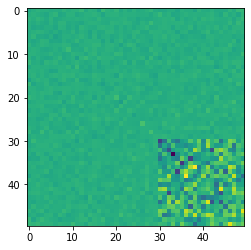

In [514]:
delta = create_two_blocks(dimension = 50, size1 = 30, value11 = 1, value12 = 1, value22 = 8)
Y = get_instance(dimension = 50, prior = 'gaussian', delta = delta)[1]
plt.imshow(Y, interpolation = 'none')
plt.show()

The plot above clearly illustrates the presence of two communities in the generated instance. In the first community the variance is 1 and the color is quite uniform, whereas in the second the variance is 8 and the color varies wildly across different nodes from the same community.

Let us now implement AMP for the inhomegenous noise 

In [515]:
def damp(new, old, damping=0.75):
    return damping * old + (1-damping) * new

def iterate_amp(precision = 1e-5, max_steps = 100, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    estimator = init
    previous_estimator = np.copy(init)
    derivative = np.zeros(N) 
    
    converged = False
    
    a_previous = 0
    b_previous = np.zeros(N)
    #parameters of the integral calculating the Bayesian-optimal denoising
    
    for timestep in range(max_steps):   
        snr = [np.mean (estimator**2) / np.mean((delta[j] * estimator)**2) for j in range(N)]
        Onsager_term = [np.mean (delta[j]**2 * derivative) for j in range(N)]
        snr = np.array(snr)
        Onsager_term = np.array(Onsager_term)
        
        next_step = np.sqrt(1 / N) * Y.T @ estimator - Onsager_term * previous_estimator
        a = snr * np.mean(estimator**2) 
        b = snr * next_step
        
        if timestep != 0:
            a = damp(a, a_previous)
            b = damp(b, b_previous)
            
        previous_estimator = estimator
        estimator, derivative = denoiser_and_derivative(b, a, prior = prior)
        derivative *= snr
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        a_previous = np.copy(a)
        b_previous = np.copy(b)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

Now we implement the denoiser functions. Note that with inhomegenous noise both parameters b and a are vectors

In [516]:
def denoiser_and_derivative(b, a, *, prior):
    if(prior == 'gaussian'):
        return b/(1+a), 1/(1+a) 
    elif prior == 'radamacher':
        return np.tanh(b), 1-np.tanh(b)**2

We now calculate the average performance of AMP over several runs

In [517]:
def get_mse(truth, estimate):
    first_possibility = np.mean((truth - estimate)**2)
    second_possibility = np.mean((truth + estimate)**2)
    return min(first_possibility, second_possibility) #It is impossible to learn the sign

def get_averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta):
    mse = []
    N = dimension
    for _ in range(seeds):
        init = 1e-3 * np.random.normal(0,1,(N,1)) # default initialisation is uninformed
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        
        # In informed initialisation start close to signal
        if initialisation == 'informed':
            init += truth 
        elif initialisation == 'spectral':
            _, init = np.linalg.eigh(Y)[N-1]
            init *= np.sqrt(len(truth))
        estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
        
    return np.mean(mse)

In [518]:
def data_amp(seeds, dimension, initialisation = 'uninformed', *, delta_collection, prior):
    
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        
        mse = get_averaged_performance(seeds = seeds,dimension = dimension, 
                                            initialisation = initialisation, 
                                            prior = prior, 
                                            delta = delta)
        
        data['parameter'].append(parameter)
        data['mse'].append(mse)

    return data

In [519]:
def create_two_blocks_collection(dimension, *, start, end, points, first_size, diag_scalar):
    N = dimension
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_two_blocks(N, first_size, parameter, parameter, diag_scalar * parameter))
    return np.array(delta_collection)


Code to solve the variational problem

In [520]:
def ExpectGibbs(qtilde):
  return 1 - 1/(qtilde + 1)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,damping = 0.2):
  term1 =  ExpectGibbs(Qtilde1)
  term2 = ExpectGibbs(Qtilde2)
  newQtilde1 = (rho1/Delta_11**2) * term1 + (rho2/Delta_12**2) * term2
  newQtilde2 = (rho1/Delta_12**2) * term1 + (rho2/Delta_22**2) * term2
  return (1-damping)*newQtilde1 + damping*Qtilde1, (1-damping)*newQtilde2 + damping*Qtilde2, np.sqrt((newQtilde1-Qtilde1)**2 + (newQtilde2-Qtilde2)**2)

def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22):
    convergence = 1000
    while (convergence > 1e-6):
        for t in range(100):
            Qtilde1, Qtilde2, convergence = iterate(Qtilde1,Qtilde2, rho1, rho2, Delta_11, Delta_12, Delta_22)
        
    return Qtilde1, Qtilde2

In [521]:
def visualize (data_amp, data_optimal):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.plot(data_optimal['parameter'], data_optimal['mse'], 
         '-y', label='Optimal', color='blue')
    plt.plot(data_amp['parameter'], data_amp['mse'], 
         '.', label='AMP', color='red')
    plt.xlabel('param')
    plt.ylabel('mse')
    plt.legend()

Generating the MMSE

In [522]:
def optimal_curve(start, end, points, diag_scalar):

    rho1, rho2 = 0.5, 0.5

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta11 = param
      Delta12 = param
      Delta22 = (diag_scalar*param)
    
      Qtilde1 = 1
      Qtilde2 = 1
    
      Qtilde1, Qtilde2 = Solve_Q(Qtilde1, Qtilde2, rho1, rho2, Delta11, Delta12, Delta22)
      MMSEVec.append(1 - np.sqrt(rho1**2 * ExpectGibbs(Qtilde1)**2 + 
                           2 * rho1 * rho2 *  ExpectGibbs(Qtilde1) * ExpectGibbs(Qtilde2) + 
                           rho2**2 * ExpectGibbs(Qtilde2)**2))
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


Computing with parameter = 0.05
Computing with parameter = 0.0816326530612245
Computing with parameter = 0.11326530612244898
Computing with parameter = 0.14489795918367349
Computing with parameter = 0.17653061224489797
Computing with parameter = 0.20816326530612245
Computing with parameter = 0.23979591836734693
Computing with parameter = 0.2714285714285714
Computing with parameter = 0.3030612244897959
Computing with parameter = 0.33469387755102037
Computing with parameter = 0.36632653061224485
Computing with parameter = 0.39795918367346933
AMP didn't converge!
Computing with parameter = 0.42959183673469387
AMP didn't converge!
Computing with parameter = 0.46122448979591835
Computing with parameter = 0.4928571428571428
Computing with parameter = 0.5244897959183673
Computing with parameter = 0.5561224489795918
Computing with parameter = 0.5877551020408164
Computing with parameter = 0.6193877551020408
Computing with parameter = 0.6510204081632653
Computing with parameter = 0.6826530612244

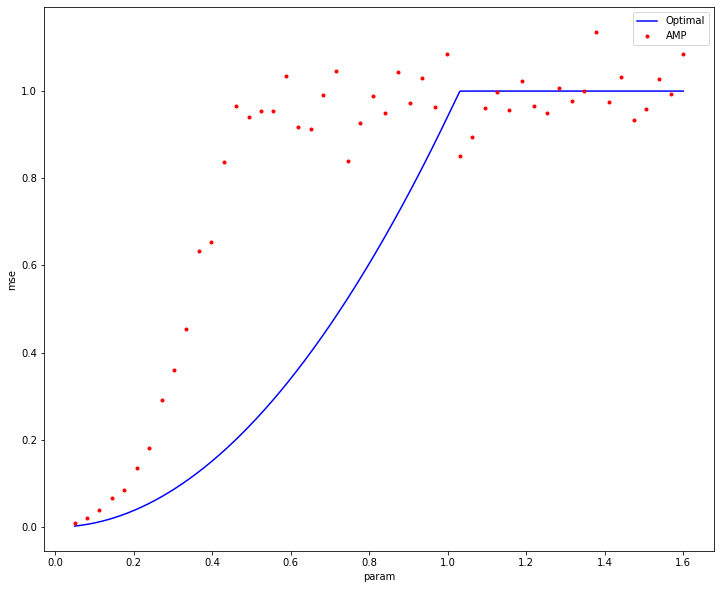

In [523]:
dimension = 100
start = 0.05
end = 1.6
points = 50
delta_collection = create_two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = 0.9)
gaussian_prior = data_amp(initialisation = 'uninformed', seeds = 7, dimension = dimension,
                                   delta_collection = delta_collection, prior = 'gaussian')
visualize(data_amp = gaussian_prior, data_optimal = 
          optimal_curve(start = start, end = end, points = 1000, diag_scalar = 0.9))